In [1]:
# Required Libraries

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import LinearSVC

### Global Script Variables

In [2]:
# Image Properties 
img_width = 1200
img_height = 1200

# Feature Extraction
baseline_loc = '/content/gdrive/My Drive/APS360/Project_37/data_processing/AlexNetFeatures2835each/'
load_features = True    # 'True' = load pre-saved features; False = extract features again

In [3]:
# Since images are saved on Google Drive, need to mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Data Processing

In [4]:
# Load the training, validation and test datasets

if not load_features:
  # Define a transform function that resizes images to img_width x img_height
  transform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop((img_width, img_height)),
                                              torchvision.transforms.Resize((50, 50)), 
                                              torchvision.transforms.ToTensor()])

  # Load training, validation and test data from Google Drive
  train_data = torchvision.datasets.ImageFolder(dataset_location+'train', transform=transform)
  val_data = torchvision.datasets.ImageFolder(dataset_location+'val', transform=transform)
  test_data = torchvision.datasets.ImageFolder(dataset_location+'test', transform=transform)

In [5]:
# Augment training data to even out the ratio of normal to pneumonia samples

if not load_features:
  print("Augmenting Data...")
    
  # Training Data is augmented using three techniques
  aug_tactics = [torchvision.transforms.RandomRotation(10),                               # rotate images by random angle between 0 and 10 degrees
                torchvision.transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),  # shift pixels by random number between 0 and 0.01*img_width pixels horizontally/vertically
                torchvision.transforms.GaussianBlur(101, (0.1, 1))]                      # blur images with randomly chosen Gaussian blur

  # Array to hold augmented data
  aug_train_data = []
  for i in range(0, 3):

    if i == 2:
      end_index = 90
    else:
      end_index = 915

    # Apply augmentation to the training dataset
    transform = torchvision.transforms.Compose([aug_tactics[i],
                                                torchvision.transforms.CenterCrop((img_width, img_height)),
                                                torchvision.transforms.Resize((50, 50)),
                                                torchvision.transforms.ToTensor()])

    # Discard augmented pneumonia samples and keep a specific number of augmented healthy samples
    aug_train_data.append(torchvision.datasets.ImageFolder(dataset_location+'train', transform=transform))
    aug_train_data[i] = torch.utils.data.Subset(aug_train_data[i], list(range(0, end_index)))


  # Create bigger set of training data
  train_data = torch.utils.data.ConcatDataset([train_data, aug_train_data[0], aug_train_data[1], aug_train_data[2]])

###Feature Extraction

In [6]:
# Function to convert loaded data into format acceptable to SVM
# This is similar to a feature extraction stage

def create_nxn_matrix(data):
  features = np.ndarray((len(data), 3*50*50))
  labels = np.ndarray(len(data))

  for idx, tens in enumerate(data, 0):    
    features[idx] = tens[0].view(3 * 50 * 50).numpy()
    labels[idx] = tens[1]

  return features, labels

In [7]:
# Function to save extracted features and labels
def save_features(features, labels, dataset):
  np.savetxt(baseline_loc + dataset + '_features.csv', features, delimiter=',')
  np.savetxt(baseline_loc + dataset + '_labels.csv', labels, delimiter=',')

In [8]:
# Function to load in pre-saved 'features'
def load_saved_features(dataset):
  features = np.genfromtxt(baseline_loc + dataset + '_features.csv', delimiter=',')
  labels = np.genfromtxt(baseline_loc + dataset + '_labels.csv', delimiter=',')
  return features, labels

In [9]:
if not load_features:
  train_features, train_labels = create_nxn_matrix(train_data)
  val_features, val_labels = create_nxn_matrix(val_data)
  test_features, test_labels = create_nxn_matrix(test_data)

  save_features(train_features, train_labels, 'train')
  save_features(val_features, val_labels, 'val')
  save_features(test_features, test_labels, 'test')

else:
  train_features, train_labels = load_saved_features('train')
  val_features, val_labels = load_saved_features('val')
  test_features, test_labels = load_saved_features('test')

### Baseline Model

Build a Linear SVM and train the classifer using the training dataset.


Reference tutorials:

* https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.partial_fit
* https://stackoverflow.com/questions/49208617/sklearn-partial-fit-not-showing-accurate-results-as-fit/51027226#51027226

In [11]:
# Create the baseline model
SVMClassifier = LinearSVC()
SVMClassifier

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [12]:
# Train the baseline model
SVMClassifier.fit(train_features, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Baseline Model Performance

In [14]:
# Determine training accuracy
SVMClassifier.score(train_features, train_labels)

0.9922398589065256

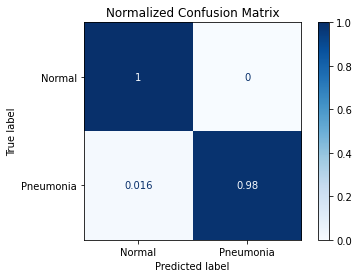

In [22]:
# Plot normalized confusion matrix for training data
disp = sklearn.metrics.plot_confusion_matrix(SVMClassifier, train_features, train_labels,
                                 display_labels=["Normal", "Pneumonia"],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Normalized Confusion Matrix")
plt.show()

In [23]:
# Determine validation accuracy
SVMClassifier.score(val_features, val_labels)

0.8861578266494179

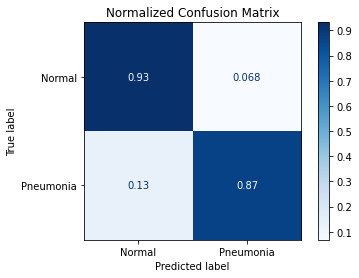

In [24]:
# Plot normalized confusion matrix for validation datat
disp = sklearn.metrics.plot_confusion_matrix(SVMClassifier, val_features, val_labels,
                                 display_labels=["Normal", "Pneumonia"],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Normalized Confusion Matrix")
plt.show()

In [25]:
# Determine test accuracy
SVMClassifier.score(test_features, test_labels)

0.9563106796116505

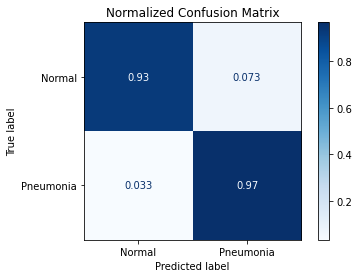

In [27]:
# Plot normalized confusion matrix for test accuracy
disp = sklearn.metrics.plot_confusion_matrix(SVMClassifier, test_features, test_labels,
                                 display_labels=["Normal", "Pneumonia"],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Normalized Confusion Matrix")
plt.show()